# (Bonus) Run STARCOP models on raw EMIT data

Demos with loading AVIRIS trained models and their zero-shot generalisation on the data from EMIT.

Note: consider this just as a bonus notebook - the code isn't very polished and should only serve as a demonstration of the data processing (from downloaded new .nc files into a format which is compatible with our pre-trained model).

Demo for .nc file downloaded from [The EMIT Open Data Portal](https://earth.jpl.nasa.gov/emit/data/data-portal/Greenhouse-Gases/) or via the LP DAAC portal at https://lpdaac.usgs.gov/tools/earthdata-search/.

In [ ]:
!pip install rasterio
!pip install --quiet --upgrade gdown

In [ ]:
# Models:
!gdown https://drive.google.com/uc?id=1Kvnc_lOBn4z-xO1HFRyLZOMEldXWQvql -O hyperstarcop_magic_rgb.zip
!git clone https://github.com/spaceml-org/STARCOP.git
!unzip -q hyperstarcop_magic_rgb.zip
!rm *.zip

In [ ]:
%cd /content/STARCOP
!pip install -r requirements.txt

In [ ]:
# additional libraries and exact versions:
!pip install git+https://github.com/spaceml-org/georeader.git
!pip install torchtext==0.14.1

In [ ]:
assert False
# please restart the runtime with the button above ^

In [4]:
%cd /content/STARCOP

/content/STARCOP


## Inference on raw L1B .nc file

Download your own .nc file from [The EMIT Open Data Portal](https://earth.jpl.nasa.gov/emit/data/data-portal/Greenhouse-Gases/) - here in this demo we will use the "EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc" file which we hosted for this demo.

In [ ]:
!gdown https://drive.google.com/uc?id=1kgG5bx3MP8z3WO7I5HrbY03uQiSDAgPJ -O EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc

In [ ]:
!pip install netCDF4
!pip install spectral

## Side code for processing EMIT data

In [5]:
#@title Run this code to initialise everything

import omegaconf
import pylab as plt
import torch
import omegaconf
import fsspec
import torch
import os
import json
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import starcop.plot as starcoplot
from starcop.torch_utils import to_device
from starcop.data.datamodule import Permian2019DataModule
from starcop.emit_tools.emit_as_datamodule import EMITDataModule
from starcop.models.model_module import ModelModule
from starcop.validation import run_validation


import spectral
import numpy as np
import matplotlib.pyplot as plt
import torch
device = torch.device("cpu")

# Note the mag1c code comes from https://github.com/markusfoote/mag1c

#!/usr/bin/env python
#
# This module is a modified version of mag1c (https://github.com/markusfoote/mag1c) that implements different
# models to estimate methane concentrations from hyperspectral images. The following is the licence of the original mag1c
# code
#
#       M ethane detection with
#       A lbedo correction and
# rewei G hted
#     L 1 sparsity
#       C ode
#
# BSD 3-Clause License
#
# Copyright (c) 2019,
#   Scientific Computing and Imaging Institute and
#   Utah Remote Sensing Applications Lab
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.
#
# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.
#
# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

# Author: Markus Foote (foote@sci.utah.edu)
import rasterio
import torch
import torch.utils.data
from typing import Tuple, Optional, Union, List, Callable
import numpy as np
import spectral
import os
from tqdm import tqdm

NODATA = -9999
SCALING = 1e5
EPSILON = 1e-9


def generate_template_from_bands(centers: Union[np.ndarray, List], fwhm: Union[np.ndarray, List]) -> np.ndarray:
    """Calculate a unit absorption spectrum for methane by convolving with given band information.

    :param centers: wavelength values for the band centers, provided in nanometers. (K, )
    :param fwhm: full width half maximum for the gaussian kernel of each band. (K, )
    :return template: the unit absorption spectum
    """
    centers = np.asarray(centers)
    fwhm = np.asarray(fwhm)
    if np.any(~np.isfinite(centers)) or np.any(~np.isfinite(fwhm)):
        raise RuntimeError('Band Wavelengths Centers/FWHM data contains non-finite data (NaN or Inf).')
    if centers.shape[0] != fwhm.shape[0]:
        raise RuntimeError('Length of band center wavelengths and band fwhm arrays must be equal.')
    lib = spectral.io.envi.open('/content/STARCOP/starcop/models/ch4.hdr',
                                '/content/STARCOP/starcop/models/ch4.lut')
    rads = np.asarray(lib.asarray()).squeeze()  # (7, 31800)
    wave = np.asarray(lib.bands.centers)  # (31800,)
    concentrations = np.asarray([0, 500, 1000, 2000, 4000, 8000, 16000])  # (7, )
    # sigma = fwhm / ( 2 * sqrt( 2 * ln(2) ) )  ~=  fwhm / 2.355
    sigma = fwhm / (2.0 * np.sqrt(2.0 * np.log(2.0)))  # (K, )
    # response = scipy.stats.norm.pdf(wave[:, None], loc=centers[None, :], scale=sigma[None, :])
    # Evaluate normal distribution explicitly
    var = sigma ** 2  # (K, )
    denom = (2 * np.pi * var) ** 0.5  # (K, )
    numer = np.exp(-(wave[:, None] - centers[None, :]) ** 2 / (2 * var))  # (31800, K)
    response = numer / denom  # (31800, K)
    # Normalize each gaussian response to sum to 1.
    response = np.divide(response, response.sum(axis=0), where=response.sum(axis=0) > 0)  # (31800, K)
    # implement resampling as matrix multiply
    resampled = rads.dot(response)  # (7, K)
    lograd = np.log(resampled, where=resampled > 0)  # (7, K)
    lsqmat = np.stack((np.ones_like(concentrations), concentrations)).T  # (7, 2)
    slope, _, _, _ = np.linalg.lstsq(lsqmat, lograd, rcond=None)  # (2, K)
    spectrum = slope[1, :] * SCALING
    target = np.stack((centers, spectrum)).T  # np.stack((np.arange(spectrum.shape[0]), centers, spectrum)).T
    return target


def get_mask_bad_bands(wave: np.ndarray) -> np.ndarray:
    """Calculates a mask of the wavelengths to keep based on water vapor absorption features.
    Rejects wavelengths: - Below 400 nm
                         - Above 2485 nm
                         - Between 1350-1420 nm (water absorption region)
                         - Between 1800-1945 nm (water absorption region)

    :param wave: Vector of wavelengths to evaluate.
    :return:
    """
    keep_mask = ~(np.logical_or(np.logical_or(wave < 400, wave > 2485),
                                np.logical_or(np.logical_and(wave > 1350,
                                                             wave < 1420),
                                              np.logical_and(wave > 1800,
                                                             wave < 1945))))
    return keep_mask


@torch.no_grad()
def func_by_groups(func: Callable[[torch.Tensor], Tuple[torch.Tensor, torch.Tensor]],
                   x: Union[np.core.memmap, np.ndarray],
                   groups: Union[np.array],
                   mask: Optional[Union[np.array]] = None,
                   disable_pbar: bool = False,
                   samples_read: int = 50) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Apply matching filter function by groups (normally the samples from the glt file which corresponds to each
    CCD sensor)

    :param func: matching filter function
    :param x: (H, W, C)  radiance tensor
    :param groups: (H, W) tensor of type int
    :param mask: (H, W) boolean mask with valid pixels
    :param samples_read.
    :param disable_pbar do not show pbar

    :return: mf, albedo tensors of dims (H, W)
    """
    groups = np.array(groups)
    albedo_out = torch.tensor(np.zeros(x.shape[:2], dtype=x.dtype) + NODATA)
    mf_out = albedo_out.clone()

    if mask is None:
        assert not isinstance(x, np.core.memmap), "If x is a memmap file provide a mask!"
        mask = np.all(x > NODATA, axis=-1)

    group_uniques = np.sort(np.unique(groups[mask]))

    range_process = list(range(0, len(group_uniques), samples_read))

    for idx_group_range_start in tqdm(range_process, total=len(range_process),
                                      desc=f"Found {len(group_uniques)} groups. Reading by groups of size {samples_read}",
                                      disable=disable_pbar):
        idx_group_range_ends = min(idx_group_range_start + samples_read, len(group_uniques))
        group_range_start = group_uniques[idx_group_range_start]
        group_range_ends = group_uniques[idx_group_range_ends - 1]

        mask_it = (groups >= group_range_start) & (groups <= group_range_ends) & mask
        rows, cols = np.where(mask_it)
        slice_rows_cols = slice(np.min(rows), np.max(rows) + 1), slice(np.min(cols), np.max(cols) + 1)

        # Force reading from the image
        x_for_second_loop = np.array(x[slice_rows_cols])

        for group_idx in group_uniques[idx_group_range_start:idx_group_range_ends]:
            # print(f"Processing group: {group_idx}")

            mask_iter = (groups[slice_rows_cols] == group_idx) & mask[slice_rows_cols]

            if np.sum(mask_iter) <= 10:
                # skip if there are very few pixels to estimate values
                continue

            mf_out_iter, albedo_out_iter = func(torch.tensor(x_for_second_loop[mask_iter, :]).unsqueeze(0))
            mf_out[slice_rows_cols][mask_iter] = mf_out_iter[0, :, 0]
            albedo_out[slice_rows_cols][mask_iter] = albedo_out_iter[0, :, 0]

    return mf_out, albedo_out


@torch.no_grad()
def acrwl1mf(x: torch.Tensor,
             template: torch.Tensor,
             num_iter: int = 30,
             albedo_override: bool = False,
             zero_override: bool = False,
             sparse_override: bool = False,
             covariance_update_scaling: float = 1.,
             alpha: float = 0.,
             compute_energy: bool = False,
             mask: Optional[torch.Tensor] = None) -> Union[
    Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor, List[float]]]:
    """Calculate the albedo-corrected reweighted-L1 matched filter on radiance data.

    :param x: Radiance Data to process. [b, p, s] See notes below on format.
    :param template: Target spectrum for detection. [s,]
    :param num_iter: Number of iterations to run.
    :param albedo_override: Do not calculate or apply albedo correction factor.
    :param zero_override: Do not apply non-negativity constraint on matched filter results.
    :param sparse_override: Do not use sparse regularization in iterations when True.
    :param covariance_update_scaling: scalar value controls contribution of previous filter values in removing target
        signal in covariance and mean updates.
    :param alpha: scalar value to perform diagonal scaling of the covariance matrix
    :param mask: An optional mask to mark where data should contribute to covariance and mean. [p,]
    :param compute_energy: Compute energy on each iteration

    :returns mf, albedo

        x must be 3-dimensional:
        batch (columns or groups of columns) x
        pixels (samples) x
        spectrum (bands)

        Notice that the samples dimension must be shared
        by the batch, so only batches/columns with the same number
        of pixels to process may be combined into a batch.
    """
    # Some constants / arrays to preallocate
    N = x.shape[1]  # number of pixels (samples)

    out = rmf(x=x, template=template, alpha=alpha, zero_override=zero_override,
              albedo_override=albedo_override, compute_energy=compute_energy,
              mask=mask, apply_scaling=False)

    mf, R = out[:2]

    if compute_energy:
        energy = [out[2]]

    # R  [b, p, 1]
    # mf [b, p, 1]

    # Initialize target
    template = template.unsqueeze(0).unsqueeze(0)  # [1, 1, s]
    if mask is not None:
        modx = x[:, mask]
    else:
        modx = x.clone()
    target = template * torch.mean(modx, dim=1, keepdim=True)

    # Reweighted L1 Algorithm
    for i in range(num_iter):
        # Re-calculate statistics
        if mask is not None:
            modx = x[:, mask] - covariance_update_scaling * R[:, mask] * mf[:, mask] * target
        else:
            modx = x - covariance_update_scaling * R * mf * target

        mu = torch.mean(modx, dim=1, keepdim=True)  # [b, 1, s]
        target = template * mu  # [b, 1, s]
        modx_minus_mu = modx - mu  # [b, p', s]
        x_minus_mu = x - mu  # [b, p, s]

        C = torch.bmm(torch.transpose(modx_minus_mu, 1, 2), modx_minus_mu) / N  # [b, s, s]
        C = C.lerp_(torch.diag_embed(torch.diagonal(C, dim1=-2, dim2=-1)), alpha)

        cholC = torch.linalg.cholesky(C)
        Cit = torch.cholesky_solve(torch.transpose(target, 1, 2), cholC)  # [b, s, 1]

        # Calculate new regularizer weights
        if not sparse_override:  # regularizer pre-defined as zeros.
            # In addition, the regularization is scaled by the albedo factor to decrease the regularization of low-signal
            # regions while increasing the confidence in retrievals over high-signal regions
            regularizer = 1 / (R * (mf + EPSILON))  # [b, p, 1]
            # regularizer = R / ( (mf + epsilon)) # I think this corresponds to sentence above??
        else:
            regularizer = 0

        # Compute matched filter with regularization
        normalizer = torch.bmm(target, Cit)  # [b, 1, 1]
        if torch.sum(torch.lt(normalizer, 1)):
            normalizer = normalizer.clamp_(min=1)
        mf = (torch.bmm(x_minus_mu, Cit) - regularizer) / (R * normalizer)
        mf = torch.nn.functional.relu_(mf)
        # Energy
        if compute_energy:
            norm_residual = torch.bmm(x_minus_mu,
                                      torch.cholesky_solve(torch.transpose(x_minus_mu, 1, 2), cholC))
            # energy_reg = torch.sum(R*regularizer*mf)
            energy.append(torch.sum(norm_residual))

    mf *= SCALING
    if compute_energy:
        return mf, R, energy

    return mf, R


@torch.no_grad()
def rmf(x: torch.Tensor,
        template: torch.Tensor,
        alpha: float = 0.,
        zero_override: bool = False,
        compute_energy: bool = False,
        albedo_override: bool = False,
        apply_scaling: bool = True,
        mask: Optional[torch.Tensor] = None) -> Union[
    Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor, float]]:
    """

    :param x: Radiance Data to process. [b, p, s] See notes below on format.
    :param template: Target spectrum for detection. [s,]
    :param alpha: scalar value to perform diagonal scaling of the covariance matrix
    :param albedo_override: Do not calculate or apply albedo correction factor.
    :param zero_override: Do not apply non-negativity constraint on matched filter results.
    :param compute_energy: Compute energy (loss function)
    :param apply_scaling: Apply scaling to the mf
    :param mask: An optional mask to mark where data should contribute to covariance and mean. [p,]

    :returns: mf result with shape [b, p, 1] and units ppm x m
    """
    N = x.shape[1]  # number of pixels (samples)
    template = template.unsqueeze(0).unsqueeze(0)  # [1, 1, s]

    if mask is not None:
        mask = torch.squeeze(mask, 0)
        assert mask.shape == x.shape[1:2], f"Unexpected shape of mask: {mask.shape} expected {x.shape[1:2]}"
        modx = x[:, mask]  # torch.zeros_like(x, dtype=dtype, device=device, layout=torch.strided)
    else:
        modx = x.clone()

    mu = torch.mean(modx, 1, keepdim=True)  # [b ,1 ,s]
    target = template * mu
    x_minus_mu = x - mu

    modx_minus_mu = modx - mu
    C = torch.bmm(torch.transpose(modx_minus_mu, 1, 2), modx_minus_mu) / N  # [b x s x p] * [b x p x s] = [b x s x s]
    C = C.lerp_(torch.diag_embed(torch.diagonal(C, dim1=-2, dim2=-1)), alpha)  # C = (1-alpha) * S + alpha * diag(S)
    # Cit, _ = torch.gesv(torch.transpose(target, 1, 2), C)  # [b x s x 1] \ [b x s x s] = [b x s x 1]
    cholC = torch.linalg.cholesky(C)
    Cit = torch.cholesky_solve(torch.transpose(target, 1, 2), cholC, upper=False)  # [b, s, 1]
    normalizer = torch.bmm(target, Cit)  # [b x 1 x s] * [b x s x 1] = [b x 1 x 1]

    if albedo_override:
        R = 1
    else:
        R = torch.bmm(x, torch.transpose(mu, 1, 2)) / torch.bmm(mu, torch.transpose(mu, 1, 2))  # [b, p, 1]

    mf = torch.bmm(x_minus_mu, Cit) / (R * normalizer)  # [b, p, 1]

    if not zero_override:
        mf = torch.nn.functional.relu_(mf)  # max(mf, 0)

    if compute_energy:
        norm_residual = torch.sum(
            torch.bmm(x_minus_mu, torch.cholesky_solve(torch.transpose(x_minus_mu, 1, 2), cholC))).item()
        # TODO add covariance part to the loss!
        det_covariances = 1 / torch.prod(torch.diagonal(cholC, dim1=-2, dim2=-1))
        norm_residual += N / 2 * torch.log(det_covariances)

        return mf, R, norm_residual

    if apply_scaling:
        mf = mf * SCALING

    return mf, R

def run_magic_on_data(data, slice_for_data, target_spec, nodata = -9999.0, show=True, save=False, figsize=20,
                      num_iter = 30, covariance_lerp_alpha = 1e-4):
    # Using code snippets from https://github.com/spaceml-org/STARCOP
    # specifically this notebook: https://github.com/spaceml-org/STARCOP/blob/training-lightning/notebooks/exploration_aviris_mag1c.ipynb
    print("Reading data", data.shape," with slice: ", slice_for_data)
    print("Target:", target_spec.shape, target_spec.dtype)
    rdn_data = np.array(data[slice_for_data]).astype(np.float64)
    print("Sliced into:", rdn_data.shape, rdn_data.dtype)

    valid_mask = np.where(np.array(data[:, :, 0]) == nodata, False, True)
    valid_mask_slice = valid_mask[slice_for_data[0:2]]
    rdn_data_valid = rdn_data[valid_mask_slice,:]
    rdn_data_valid_torch = torch.Tensor(rdn_data_valid).unsqueeze(0) # [b, p, s]

    mf_out, albedo_out = acrwl1mf(rdn_data_valid_torch, target_spec, num_iter=num_iter, alpha=covariance_lerp_alpha)

    magic_output = np.zeros(rdn_data.shape[:2],dtype=rdn_data.dtype) + nodata
    magic_output[valid_mask_slice] = np.array(mf_out)[0,:,0]

    # plt.figure(figsize=(figsize,figsize),tight_layout=True)
    # plt.imshow(magic_output, vmin=0, vmax=5000)
    # plt.title("mag1c on a full tile modified")
    # if save is not False:
    #     plt.savefig(save)

    # if show:
    #     plt.show()

    return magic_output

def prep_emit_data(data, wavelengths, bandwidths):
    wavelengths = np.array(wavelengths)
    bandwidths = np.array(bandwidths)

    # for tests we can also use just 5 instead of the around 8 that EMIT has with:
    # faked_bandwidths = 5.0 * np.ones_like(bandwidths)
    # bandwidths = faked_bandwidths

    band_keep = get_mask_bad_bands(wavelengths)
    use_wavelength_range = (2122, 2488)  # defaults in mag1c
    use_wavelength_range = (2000, 2488)  # increase range
    # Remove bands out of the absortion range of methane
    band_keep[wavelengths < use_wavelength_range[0]] = False
    band_keep[wavelengths > use_wavelength_range[1]] = False
    idx_keep, = np.where(band_keep)  # Which bands to keep -> 72 bands

    target = generate_template_from_bands(centers=wavelengths, fwhm=bandwidths)
    # plt.figure(figsize=(10, 5))
    # plt.plot(target[:, 0], target[:, 1])
    # plt.vlines(use_wavelength_range, ymin=-1.5, ymax=0, color="C3")
    # plt.show()

    target_spec = torch.from_numpy(target[band_keep, 1]).to(device=device, dtype=torch.float32)

    ### Slice data:

    slice_ = (slice(None),slice(None)) # all, but slow!
    slice_bands = slice(idx_keep[0], idx_keep[-1] + 1)
    slice_with_bands = slice_ + (slice_bands,)

    return data, slice_with_bands, target_spec, wavelengths

# Our own code, which was edited
# from a emit data processing source at: https://github.com/emit-sds/emit-utils/blob/develop/emit_utils/reformat.py
import argparse
import netCDF4
import numpy as np
from spectral.io import envi
import os

def envi_header(inputpath):
    """
    Convert a envi binary/header path to a header, handling extensions
    Args:
        inputpath: path to envi binary file
    Returns:
        str: the header file associated with the input reference.
    """
    if os.path.splitext(inputpath)[-1] == '.img' or os.path.splitext(inputpath)[-1] == '.dat' or os.path.splitext(inputpath)[-1] == '.raw':
        # headers could be at either filename.img.hdr or filename.hdr.  Check both, return the one that exists if it
        # does, if not return the latter (new file creation presumed).
        hdrfile = os.path.splitext(inputpath)[0] + '.hdr'
        if os.path.isfile(hdrfile):
            return hdrfile
        elif os.path.isfile(inputpath + '.hdr'):
            return inputpath + '.hdr'
        return hdrfile
    elif os.path.splitext(inputpath)[-1] == '.hdr':
        return inputpath
    else:
        return inputpath + '.hdr'


envi_typemap = {
    'uint8': 1,
    'int16': 2,
    'int32': 3,
    'float32': 4,
    'float64': 5,
    'complex64': 6,
    'complex128': 9,
    'uint16': 12,
    'uint32': 13,
    'int64': 14,
    'uint64': 15
}


def single_image_ortho(img_dat, glt, glt_nodata_value=0, set_nodata=np.nan):
    """Orthorectify a single image

    Args:
        img_dat (array like): raw input image
        glt (array like): glt - 2 band 1-based indexing for output file(x, y)
        glt_nodata_value (int, optional): Value from glt to ignore. Defaults to 0.

    Returns:
        array like: orthorectified version of img_dat
    """
    outdat = np.ones((glt.shape[0], glt.shape[1], img_dat.shape[-1])) * set_nodata
    valid_glt = np.all(glt != glt_nodata_value, axis=-1)
    glt[valid_glt] -= 1  # account for 1-based indexing
    outdat[valid_glt, :] = img_dat[glt[valid_glt, 1], glt[valid_glt, 0], :]
    return outdat

def load_nc_file(input_netcdf = "what.nc", output_dir="", output_type='ENVI', interleave='BIL', overwrite=False):
    nc_ds = netCDF4.Dataset(input_netcdf, 'r', format='NETCDF4')
    orthorectify_params = {}

    glt = np.zeros(list(nc_ds.groups['location']['glt_x'].shape) + [2], dtype=np.int32)
    glt[..., 0] = np.array(nc_ds.groups['location']['glt_x'])
    glt[..., 1] = np.array(nc_ds.groups['location']['glt_y'])

    if output_type == 'ENVI':
        dataset_names = list(nc_ds.variables.keys())
        for ds in dataset_names:
            output_name = os.path.join(output_dir, os.path.splitext(os.path.basename(input_netcdf))[0] + '_' + ds)
            if os.path.isfile(output_name+"_RGB") and os.path.isfile(output_name+"_magic") and overwrite is False:
                print(f'File {output_name} already exists. Skipping!')
                return None, None, None, None

            metadata = {
                'lines': nc_ds[ds].shape[0],
                'samples': nc_ds[ds].shape[1],
                'bands': nc_ds[ds].shape[2],
                'interleave': interleave,
                'header offset': 0,
                'file type': 'ENVI Standard',
                'data type': envi_typemap[str(nc_ds[ds].dtype)],
                'byte order': 0
            }

            for key in list(nc_ds.__dict__.keys()):
                if key == 'summary':
                    metadata['description'] = nc_ds.__dict__[key]
                elif key not in ['geotransform', 'spatial_ref']:
                    metadata[key] = f'{{ {nc_ds.__dict__[key]} }}'

            orthorectify_params["glt"] = glt
            gt = np.array(nc_ds.__dict__["geotransform"])
            orthorectify_params["map info"] = f'{{Geographic Lat/Lon, 1, 1, {gt[0]}, {gt[3]}, {gt[1]}, {gt[5] * -1},WGS-84}}'
            orthorectify_params["coordinate system string"] = f'{{ {nc_ds.__dict__["spatial_ref"]} }}'

            band_parameters = nc_ds['sensor_band_parameters'].variables.keys()
            for bp in band_parameters:
                if bp == 'wavelengths' or bp == 'radiance_wl':
                    metadata['wavelength'] = np.array(nc_ds['sensor_band_parameters'].variables[bp]).astype(
                        str).tolist()
                elif bp == 'radiance_fwhm':
                    metadata['fwhm'] = np.array(nc_ds['sensor_band_parameters'].variables[bp]).astype(str).tolist()
                elif bp == 'observation_bands':
                    metadata['band names'] = np.array(nc_ds['sensor_band_parameters'].variables[bp]).astype(
                        str).tolist()
                else:
                    metadata[bp] = np.array(nc_ds['sensor_band_parameters'].variables[bp]).astype(str).tolist()

            if 'wavelength' in list(metadata.keys()) and 'band names' not in list(metadata.keys()):
                metadata['band names'] = metadata['wavelength']

            data = np.array(nc_ds[ds])
    return data, metadata, output_name, orthorectify_params

def orthorectify_data(data, metadata, orthorectify_params):
    metadata['lines'] = orthorectify_params["glt"].shape[0]
    metadata['samples'] = orthorectify_params["glt"].shape[1]
    metadata['map info'] = orthorectify_params["map info"]
    metadata['coordinate system string'] = orthorectify_params["coordinate system string"]
    data = single_image_ortho(data, orthorectify_params["glt"])
    return data, metadata


In [6]:
def process_EMIT_nc_file_with_magic(input_netcdf = "what.nc", output_dir="", output_type='ENVI', interleave='BIL',
                              orthorectify=True, overwrite=True, no_data_to_nans = True):
    # if overwrite is set to False, we will skip already existing files...
    print("File:", input_netcdf.split("/")[-1])
    if os.path.isdir(output_dir) is False:
        err_str = f'Output directory {output_dir} does not exist - please create or try again'
        raise AttributeError(err_str)

    # 01 LOAD RAW DATA
    data, metadata, output_name, orthorectify_params = load_nc_file(input_netcdf, output_dir, output_type, interleave, overwrite)
    if data is None:
        return None # skipped

    wavelengths = np.array(metadata['wavelength']).astype(float).tolist()
    bandwidths = np.array(metadata['fwhm']).astype(float).tolist()
    print("We have ", len(wavelengths), "wavelengths, from", wavelengths[0], " nm to", wavelengths[-1], " nm...")
    print("We have ", len(bandwidths), "bandwidths, from", bandwidths[0], " nm to", bandwidths[-1], " nm...")


    # 02 RUN MAG1C
    data, slice_for_data, target_spec, _ = prep_emit_data(data, wavelengths, bandwidths)
    magic_output = run_magic_on_data(data=data, slice_for_data=slice_for_data, target_spec=target_spec,
                      show=False, nodata=-9999.0)
    # set the mag1c no data to np.nan (for better visualisation...)
    if no_data_to_nans:
        magic_output = np.where(magic_output == -9999.0, np.nan, magic_output)

    # 03 ORTHORECTIFY AND GEOTAG THE RESULT
    rgb_bands = [36, 22, 10, 0] # note the 4th band will be rewritten ...
    data = data[:, :, rgb_bands]
    data[:, :, -1] = magic_output # < we overwrite the 0th band

    if orthorectify:
        data, metadata = orthorectify_data(data, metadata, orthorectify_params)

    # 04 SAVE
    # RGB
    rgb = data[:,:,[0,1,2]]
    if no_data_to_nans:
        rgb = np.where(rgb == -9999.0, np.nan, rgb)

    magic = data[:,:,[3]]

    metadata['bands'] = 3  # RGB
    file_name = output_name + "_RGB"
    envi_ds = envi.create_image(envi_header(file_name), metadata, ext='', force=True)
    mm = envi_ds.open_memmap(interleave='bip', writable=True)
    mm[...] = rgb
    del mm, envi_ds # flush?

    metadata['bands'] = 1  # mag1c
    file_name = output_name + "_magic"
    envi_ds = envi.create_image(envi_header(file_name), metadata, ext='', force=True)
    mm = envi_ds.open_memmap(interleave='bip', writable=True)
    mm[...] = magic
    del mm, envi_ds

    return rgb, magic

In [9]:
input_netcdf = "/content/STARCOP/EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc"
rgb_loaded, magic_loaded = process_EMIT_nc_file_with_magic(input_netcdf = input_netcdf, output_dir=".", output_type='ENVI', interleave='BIL',
                              orthorectify=False, overwrite=True, no_data_to_nans = True)
# note: on Colab this might have problems with memory, orthorectification likely wouldn't pass at all

File: EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc
We have  285 wavelengths, from 381.00558  nm to 2492.9238  nm...
We have  285 bandwidths, from 8.415  nm to 8.809  nm...
Reading data (1280, 1242, 285)  with slice:  (slice(None, None, None), slice(None, None, None), slice(218, 283, None))
Target: torch.Size([65]) torch.float32
Sliced into: (1280, 1242, 65) float64


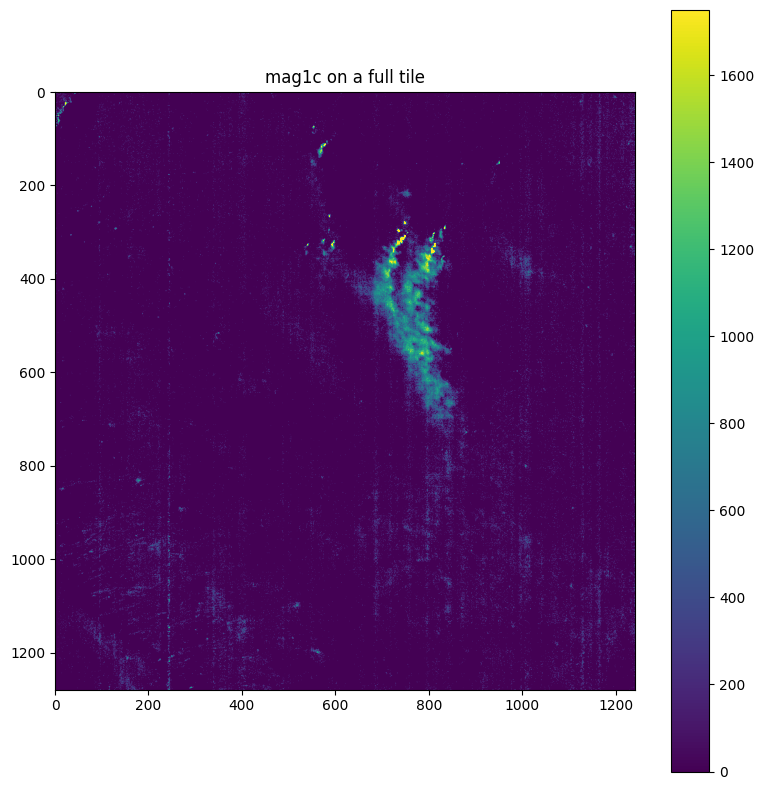

In [14]:
import pylab as plt
plt.figure(figsize=(8,8),tight_layout=True)
plt.imshow(magic_loaded, vmin=0, vmax=1750)
plt.title("mag1c on a full tile")
plt.colorbar()
plt.show()

^ This is the visualisation of the interative matched filter approach called mag1c (from [here](https://github.com/markusfoote/mag1c)). This product itself can sometimes be quite noisy (we selected one with a clear plume for this demo) - the task of the trained models is then to distinguish between real plumes present in the data and confounder surfaces, that also show up as active in this product (please read the paper for more details).

Besides plotting the matched filter product above, we also saved the bands neccessary for our model to process (just to note, these are also much smaller than the original .nc file). We can list them below:

In [15]:
# We have also saved the files that our STARCOP model needs (rgb bands and the mag1c product - note that they are not normalised...)
!ls

bash								 LICENSE
EMIT_L1B_RAD_001_20220827T060753_2223904_013.nc			 README.md
EMIT_L1B_RAD_001_20220827T060753_2223904_013_radiance_magic	 requirements.txt
EMIT_L1B_RAD_001_20220827T060753_2223904_013_radiance_magic.hdr  scripts
EMIT_L1B_RAD_001_20220827T060753_2223904_013_radiance_RGB	 starcop
EMIT_L1B_RAD_001_20220827T060753_2223904_013_radiance_RGB.hdr


In [16]:
rgb_path = "EMIT_L1B_RAD_001_20220827T060753_2223904_013_radiance_RGB"
magic_path = "EMIT_L1B_RAD_001_20220827T060753_2223904_013_radiance_magic"

# load raw data:
with rasterio.open(rgb_path) as src:
  rgb = src.read()
with rasterio.open(magic_path) as src:
  magic = src.read()

_,w,h = rgb.shape
print("loaded rgb:", rgb.shape, "and magic", magic.shape)

loaded rgb: (3, 1280, 1242) and magic (1, 1280, 1242)


/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [17]:
import math
# Data re-normalisation to fit the range of our models
# (these params were found from statistics of the training datasets and data ranges)

# DIV the EMIT data by
MAGIC_DIV_BY = 240.
RGB_DIV_BY = 20.
# clipping too large values
MAGIC_CLIP_TO = [0.,2.]
RGB_CLIP_TO =   [0.,2.]
# MULT_BY to get it back to the range we saw in the AVIRIS data ...
MAGIC_MULT_BY = 1750.
RGB_MULT_BY =   60.

# CROP SHAPE
w_32mult, h_32mult = math.floor(w / 32) * 32, math.floor(h / 32) * 32
rgb   = rgb[:, 0:w_32mult, 0:h_32mult]
magic = magic [:, 0:w_32mult, 0:h_32mult]
# label = label [0:w_32mult, 0:h_32mult]

# NORMALISE
# emit rgb has max ~22
e_magic = np.clip(magic / MAGIC_DIV_BY, MAGIC_CLIP_TO[0], MAGIC_CLIP_TO[1]) * MAGIC_MULT_BY
e_rgb = np.clip(rgb / RGB_DIV_BY, RGB_CLIP_TO[0], RGB_CLIP_TO[1]) * RGB_MULT_BY

In [18]:
# into the format the model expects
input_data = torch.ones((1,4,w_32mult, h_32mult))
input_data[0][0] = torch.from_numpy(e_magic[0])
input_data[0][1:] = torch.from_numpy(e_rgb)

In [19]:
hsi_model_path = "/content/hyperstarcop_magic_rgb/final_checkpoint_model.ckpt"
hsi_config_path = "/content/hyperstarcop_magic_rgb/config.yaml"

device = torch.device("cuda:0")
fs = fsspec.filesystem("gs")
config_general = omegaconf.OmegaConf.load("scripts/configs/config.yaml")
labels_filename = "label_nonortho.tif"

def load_model_with_emit(model_path, config_path):
    config_model = omegaconf.OmegaConf.load(config_path)
    config = omegaconf.OmegaConf.merge(config_general, config_model)

    model = ModelModule.load_from_checkpoint(model_path, settings=config)
    model.to(device)
    model.eval() # !

    print("Loaded model with",model.num_channels,"input channels")

    return model, config

hsi_model, hsi_config = load_model_with_emit(hsi_model_path, hsi_config_path)
print("successfully loaded HyperSTARCOP model!")

Loaded model with 4 input channels
successfully loaded HyperSTARCOP model!


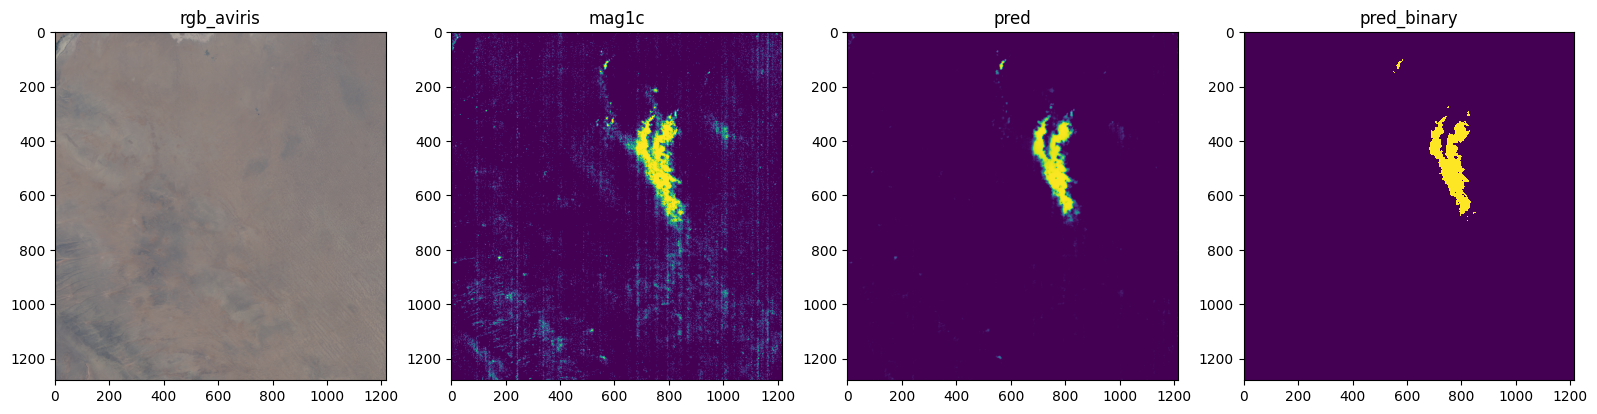

In [20]:
# Very low level access to our model:

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchmetrics
import starcop.plot as starcoplot
import starcop.metrics as starcopmetrics

confusion_metric = torchmetrics.ConfusionMatrix(num_classes=2)

idx = 0
plume_data = {}
plume_data["input"] = input_data
plume_data["output"] = torch.zeros((1,1,w_32mult, h_32mult)) # < for label we just set zeros for this demo ...
plume_data["weight_loss"] = torch.zeros((1,1,w_32mult, h_32mult))
plume_data["id"] = [0]
plume_data["has_plume"] = [False]

with torch.no_grad():
    # run prediction:
    plume_data = hsi_model.batch_with_preds(to_device(plume_data, hsi_model.device))

# plot results:
fig = starcoplot.plot_batch(to_device(plume_data,"cpu"), input_products=hsi_model.hparams["settings"]["dataset"]["input_products"],
                            products_plot=["rgb_aviris", "mag1c", "pred", "pred_binary"], figsize_ax=(4, 4))
plt.show(fig)
plt.close()


^ This visualisation should be the same as the one in the EMIT inference notebook - the difference is, that here we loaded the data from the original raw .nc files, while in the other one we used the saved and processed EMIT evaluation dataset.

For experimenting with new events (new downloaded .nc files), we suggest using the codes present in this notebook to see our model's predictions on them.